The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.

In [1]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Then we import the covid19_inference module.

In [2]:
try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

We obtain the JHU data for France.

In [3]:
jhu = cov19.data_retrieval.JHU()
jhu.download_confirmed()
data_retrieval = datetime.datetime.now().strftime(format="%d/%m/%Y %H:%M")
print("Date and time of data retrieval: " + data_retrieval)

# extract confirmed
bd = datetime.datetime(2020,2,26) # when cases began to increase quickly
ed = datetime.datetime(2020,5,10) # 10/05/2020
total_cases = jhu.get_confirmed(country = "France", begin_date= bd, end_date = ed )

Date and time of data retrieval: 16/05/2020 14:49


In [4]:
new_cases_obs = np.diff(total_cases.to_numpy().flatten())
print(new_cases_obs)

[   20    19    43    30    61    13    84    92   276   303   177    83
   575   499     0  1388   815    36  2151  1032  1409  1846  1788  1705
  1780  3880  2499  2978  3951  3851  4703  2603  4462  7657  4922  2180
  5273  4298  1912  3931  3820  3894  4309  4372  3125 26849  3682  4971
  3220 12490  2009     2  4925  2382  2775 -2188  2323  1649  1692   576
  3743  3090 -2510   756     6  1213   407   658  1104  3537   694  1284
   580   312]


For the choice of changing points, see https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_France
- on 12/03, Macron held a speech, some measures against large gatherings, announced university closure, mild social distancing encouraged
- on 17/03, nationwide lockdown
- 24/03, lockdown measures strengthened (a bit)
- 11/04, before easter
- 13/04, after easter

We will not use data after 10/05 because with the deconfinement, the testing policy changed.

All the parameters chosen in the following amount to a quick, naive application of the model to France. Delays are set as for Germany.

In [5]:
date_begin_data = bd
date_end_data   = ed
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 16

prior_date_macron_speech = datetime.datetime(2020,3,12)
prior_date_confinement_begin =  datetime.datetime(2020,3,17)
prior_date_stronger_measures =  datetime.datetime(2020,3,24)
prior_date_before_easter = datetime.datetime(2020,4,10)
prior_date_after_easter = datetime.datetime(2020,4,13)

change_points = [dict(pr_mean_date_transient = prior_date_macron_speech,
                      pr_sigma_date_transient = 4, #reduced due to closeness to the confinement begin
                      pr_median_lambda = 0.3,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_confinement_begin,
                      pr_sigma_date_transient = 4, #reduced
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_stronger_measures,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/16,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_before_easter,
                      pr_sigma_date_transient = 3, #reduced
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_after_easter,
                      pr_sigma_date_transient = 3, #reduced
                      pr_median_lambda = 1/16,
                      pr_sigma_lambda = 1)]

New prior implemented

In [6]:
params_model = dict(new_cases_obs = new_cases_obs[:],
                    data_begin = date_begin_data,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 67e6) 

# The model is specified in a context. Each function in this context has access to the model parameters set
with cov19.Cov19Model(**params_model) as model:
    # Create an array of the time dependent infection rate lambda
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1/8), sigma=0.2)
    pr_median_delay = 10 # normal delay
    
    # This builds a decorrelated prior for I_begin for faster inference. 
    # It is not necessary to use it, one can simply remove it and use the default argument 
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.make_prior_I(lambda_t_log, mu, pr_median_delay = pr_median_delay)
    
    # Use lambda_t_log and mu to run the SIR model
    new_I_t = cov19.SIR(lambda_t_log, mu, pr_I_begin = prior_I)
    
    # Delay the cases by a lognormal reporting delay
    new_cases_inferred = cov19.delay_cases(new_I_t, pr_median_delay=pr_median_delay, 
                                               pr_median_scale_delay=0.3, name_delayed_cases="new_cases")
    # normal delay and normal scale
    
    # NO weekend effect
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.student_t_likelihood(new_cases_inferred)

INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5


In [7]:
trace = pm.sample(model=model, tune=3000, draws=500, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 676.77:   8%|▊         | 16199/200000 [04:41<53:08, 57.64it/s]  
Convergence achieved at 16200
INFO     [pymc3.variational.inference] Convergence achieved at 16200
Interrupted at 16,199 [8%]: Average Loss = 760.38
INFO     [pymc3.variational.inference] Interrupted at 16,199 [8%]: Average Loss = 760.38
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, delay_log, I_begin_ratio_log, mu, transient_len_5_log, transient_len_4_log, transient_len_3_log, transient_len_2_log, transient_len_1_log, transient_day_5, transient_day_4, transient_day_3, transient_day_2, transient_day_1, lambda_5_log, lambda_4_log, lambda_3_log, lambda_2_log, lambda_1_log, lambda_0_log]
INFO     [pymc3] NUTS: [sigma_obs, delay_log, I_begin_ratio_log, mu, tr

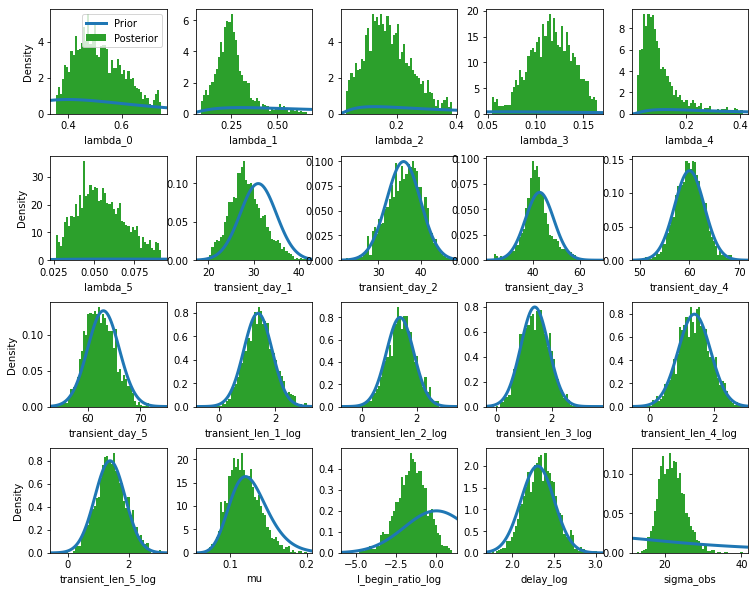

In [8]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'), lambda_exp=True)
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)


Text(0, 0.5, 'Daily new cases')

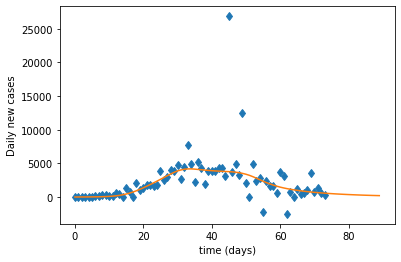

In [9]:
plt.plot(new_cases_obs, 'd')
plt.plot(np.median(trace.new_cases, axis=0))

plt.xlabel("time (days)")
plt.ylabel("Daily new cases")

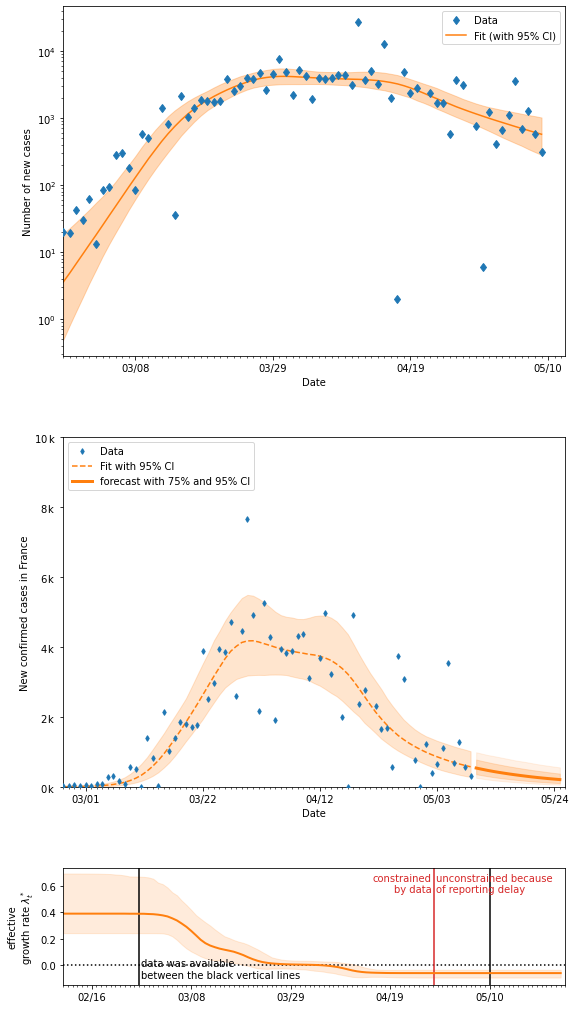

In [10]:
fig.subplots_adjust(wspace=0.25, hspace=0.4)
fig, axes = cov19.plotting.plot_cases(trace, new_cases_obs, bd - datetime.timedelta(days = diff_data_sim), diff_data_sim, country="France", ylim=10000, big=True)

With limit 10000 in the non-logarithmic plot in order maintain visibility.

In [11]:
from covid19_inference import data_collection as cov19dc
from importlib import reload

We save the results using the data_collection module

In [12]:
lockdown_date = prior_date_confinement_begin
lockdown_type = "confinement"
other_vars = {"bd": bd, "ed": ed, 
              "diff_data_sim": diff_data_sim, "num_days_forecast": num_days_forecast, 
              "lockdown_date": lockdown_date, "lockdown_type": lockdown_type, "data_retrieval": data_retrieval,
              "tune": 3000, "draws": 500}
cov19dc.update_collection("France", "JHU", trace, model.unobserved_RVs, change_points, other_vars)